In [1]:
import os
from pydub import AudioSegment

# 디렉토리 설정
input_dir = './m4a'
output_dir = './wav'

# 출력 디렉토리 생성 (존재하지 않으면)
os.makedirs(output_dir, exist_ok=True)

# m4a 파일 리스트
files = [f for f in os.listdir(input_dir) if f.endswith('.m4a')]

for file in files:
    # 파일 경로 설정
    m4a_path = os.path.join(input_dir, file)
    wav_path = os.path.join(output_dir, file.replace('.m4a', '.wav'))

    # m4a -> wav 변환
    sound = AudioSegment.from_file(m4a_path, format="m4a")
    sound.export(wav_path, format="wav")

In [2]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split

def extract_rms_from_wav(filepath, sr=22050, frame_length=2048, hop_length=512):
    y, _ = librosa.load(filepath, sr=sr)
    rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length).squeeze()
    return rms

def create_dataset_from_dir(wav_dir, seq_len=10):
    X, y = [], []
    for fname in os.listdir(wav_dir):
        if fname.endswith(".wav"):
            full_path = os.path.join(wav_dir, fname)
            rms = extract_rms_from_wav(full_path)
            for i in range(len(rms) - seq_len):
                X.append(rms[i:i+seq_len])
                y.append(rms[i+seq_len])
    X = np.array(X)[..., np.newaxis]  # (samples, seq_len, 1)
    y = np.array(y)
    return X, y

# 데이터 준비
X, y = create_dataset_from_dir('./wav', seq_len=10)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
# 데이터 분할 및 샘플링
def split_with_stride(X, y, train_ratio=0.8, max_total_samples=None):
    total_samples = len(X)

    if max_total_samples and total_samples > max_total_samples:
        stride = total_samples // max_total_samples
        X = X[::stride]
        y = y[::stride]
        print(f"Sampled with stride {stride}, reduced to {len(X)} samples")

    split_idx = int(len(X) * train_ratio)
    X_train, X_val = X[:split_idx], X[split_idx:]
    y_train, y_val = y[:split_idx], y[split_idx:]

    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    return X_train, X_val, y_train, y_val

In [4]:
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import GRU, Dense # type: ignore

def build_gru_model(input_shape):
    model = Sequential([
        GRU(64, input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.summary()
    return model

In [9]:
from tensorflow.keras.callbacks import EarlyStopping # type: ignore

WAV_DIR = './wav'
SEQ_LEN = 10 # 입력 시퀀스 길이
MAX_SAMPLES = 10000  # 총 사용할 시퀀스 수 제한 (원하지 않으면 None)

# EarlyStopping 콜백 정의
early_stop = EarlyStopping(
    monitor='val_loss',     # 검증 손실 기준
    patience=5,             # 5 에폭 연속으로 개선 없으면 종료
    restore_best_weights=True  # 가장 좋았던 가중치로 복원
)

# 데이터 준비
X, y = create_dataset_from_dir(WAV_DIR, seq_len=SEQ_LEN)
X_train, X_val, y_train, y_val = split_with_stride(X, y, train_ratio=0.8, max_total_samples=MAX_SAMPLES)

# 모델 구축 및 학습
model = build_gru_model(input_shape=(SEQ_LEN, 1))
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

model.save('gru_noise_model.h5')

Sampled with stride 41, reduced to 10014 samples
Training samples: 8011
Validation samples: 2003
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 64)                12864     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 12,929
Trainable params: 12,929
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
251/251 [==============================] - 3s 6ms/step - loss: 2.3059e-04 - val_loss: 8.9528e-05
Epoch 2/50
251/251 [==============================] - 1s 5ms/step - loss: 7.6933e-05 - val_loss: 4.7408e-05
Epoch 3/50
251/251 [==============================] - 1s 5ms/step - loss: 4.6068e-05 - val_loss: 3.1665e-05
Epoch 4/50
251/251 [=====

63/63 [==============================] - 0s 2ms/step


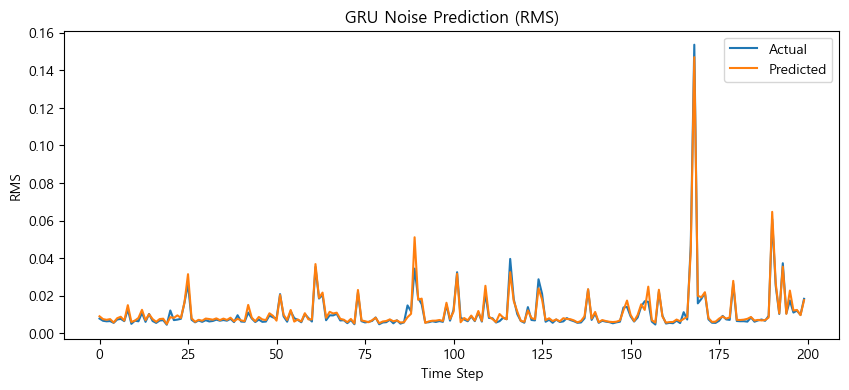

In [10]:
# 앞 200개 시퀀스 데이터에 대하여 예측 시각화
import matplotlib.pyplot as plt

y_pred = model.predict(X_val).squeeze()

plt.figure(figsize=(10, 4))
plt.plot(y_val[:200], label='Actual')
plt.plot(y_pred[:200], label='Predicted')
plt.legend()
plt.title('GRU Noise Prediction (RMS)')
plt.xlabel('Time Step')
plt.ylabel('RMS')
plt.show()

In [11]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model # type: ignore

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
SEQ_LEN = 10 # 입력 시퀀스 길이
os.makedirs('./plots', exist_ok=True)
model = tf.keras.models.load_model('gru_noise_model.h5')

def make_sequences(data, seq_len=SEQ_LEN):
    return np.array([data[i:i+seq_len] for i in range(len(data)-seq_len)])[..., np.newaxis]

prediction_results = {}

for fname in os.listdir('./wav'):
    if fname.endswith(".wav"):
        path = os.path.join('./wav', fname)
        rms = extract_rms_from_wav(path)
        X_seq = make_sequences(rms)
        
        if len(X_seq) == 0:
            print(f"{fname}: 시퀀스가 부족하여 예측 생략")
            continue
        
        preds = model.predict(X_seq).squeeze()
        base = os.path.splitext(fname)[0]

        # 예측 그래프를 PNG로 저장
        plt.figure(figsize=(10, 4))
        plt.plot(rms[SEQ_LEN:], label='Actual RMS')
        plt.plot(preds, label='Predicted RMS')
        plt.title(f'Predicted vs Actual RMS - {base}')
        plt.xlabel('Time Step')
        plt.ylabel('RMS')
        plt.legend()
        plt.tight_layout()

        plot_path = os.path.join('./plots', f'{base}_pred.png')
        plt.savefig(plot_path)
        plt.close()

82/82 [==============================] - 0s 2ms/step
